In [1]:
from rdkit import Chem
from rdkit.Chem.rdMolTransforms import GetAngleDeg


In [2]:
from scipy.special import rel_entr
def get_kld(P, Q):
    #calculate (P || Q)
#     Q = (Q+1e-32) / np.sum(Q+1e-32)
    v = rel_entr(P, Q)
#     v = v[~np.isinf(v)]
    return sum(v)

# Rings

In [3]:
def find_i_ring(mol, i):  # whether mol has ring with size i
    ssr = Chem.GetSymmSSSR(mol)
    for ring in ssr:
        if len(ring) == i:
            return True
    return False

# Bond 

bond angles

In [4]:
def get_bond_angle(mol, bond_smi='CCC'):
    """
    Find bond pairs (defined by bond_smi) in mol and return the angle of the bond pair
    bond_smi: bond pair smiles, e.g. 'CCC'
    """
    deg_list = []
    substructure = Chem.MolFromSmiles(bond_smi)
    bond_pairs = mol.GetSubstructMatches(substructure)
    for pair in bond_pairs:
        deg_list += [GetAngleDeg(mol.GetConformer(), *pair)]
        assert mol.GetBondBetweenAtoms(pair[0], pair[1]) is not None
        assert mol.GetBondBetweenAtoms(pair[2], pair[1]) is not None
    return deg_list

dihedral angles

In [5]:
def get_bond_symbol(bond):
    """
    Return the symbol representation of a bond
    """
    a0 = bond.GetBeginAtom().GetSymbol()
    a1 = bond.GetEndAtom().GetSymbol()
    b = str(int(bond.GetBondType())) # single: 1, double: 2, triple: 3, aromatic: 12
    return ''.join([a0, b, a1])

In [6]:
def get_triple_bonds(mol):
    """
    Get all the bond triplets in a molecule
    """
    valid_triple_bonds = []
    for idx_bond, bond in enumerate(mol.GetBonds()):
        idx_begin_atom = bond.GetBeginAtomIdx()
        idx_end_atom = bond.GetEndAtomIdx()
        begin_atom = mol.GetAtomWithIdx(idx_begin_atom)
        end_atom = mol.GetAtomWithIdx(idx_end_atom)
        begin_bonds = begin_atom.GetBonds()
        valid_left_bonds = []
        for begin_bond in begin_bonds:
            if begin_bond.GetIdx() == idx_bond:
                continue
            else:
                valid_left_bonds.append(begin_bond)
        if len(valid_left_bonds) == 0:
            continue

        end_bonds = end_atom.GetBonds()
        for end_bond in end_bonds:
            if end_bond.GetIdx() == idx_bond:
                continue
            else:
                for left_bond in valid_left_bonds:
                    valid_triple_bonds.append([left_bond, bond, end_bond])
    return valid_triple_bonds


In [7]:
def get_dihedral_angle(mol, bonds_ref_sym):
    """
    find bond triplets (defined by bonds_ref_sym) in mol and return the dihedral angle of the bond triplet
    bonds_ref_sym: a symbol string of bond triplet, e.g. 'C1C-C1C-C1C'
    """
    # bonds_ref_sym = '-'.join(get_bond_symbol(bonds_ref))
    bonds_list = get_triple_bonds(mol)
    angles_list = []
    for bonds  in bonds_list:
        sym = '-'.join([get_bond_symbol(b) for b in bonds])
        sym1 = '-'.join([get_bond_symbol(b) for b in bonds][::-1])
        atoms = []
        if (sym == bonds_ref_sym) or (sym1 == bonds_ref_sym): 
            if (sym1 == bonds_ref_sym):
                bonds = bonds[::-1]
            bond0 = bonds[0]
            atom0 = bond0.GetBeginAtomIdx()
            atom1 = bond0.GetEndAtomIdx()

            bond1 = bonds[1]
            atom1_0 = bond1.GetBeginAtomIdx()
            atom1_1 = bond1.GetEndAtomIdx()
            if atom0 == atom1_0:
                i, j, k =atom1, atom0, atom1_1
            elif atom0 == atom1_1:
                i, j, k =atom1, atom0, atom1_0
            elif atom1 == atom1_0:
                i, j, k =atom0, atom1, atom1_1
            elif atom1 == atom1_1:
                i, j, k =atom0, atom1, atom1_0
                
            bond2 = bonds[2]
            atom2_0 = bond2.GetBeginAtomIdx()
            atom2_1 = bond2.GetEndAtomIdx()
            if atom2_0 == k:
                l = atom2_1
            elif atom2_1 == k:
                l = atom2_0
            # print(i,j,k,l)
            angle = Chem.rdMolTransforms.GetDihedralDeg(mol.GetConformer(), i,j,k,l)
            angles_list.append(angle)
    return angles_list

test

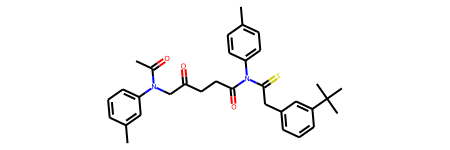

In [24]:
from rdkit.Chem.Draw import IPythonConsole
from rdkit import Chem
from rdkit.Chem import AllChem
mol = Chem.MolFromSmiles('CC(=O)N(CC(=O)CCC(=O)N(C(=S)Cc1cccc(C(C)(C)C)c1)c1ccc(C)cc1)c1cccc(C)c1')
mol

In [25]:
mol = Chem.AddHs(mol)
rmsd_list = []
# predict 3d
confId = AllChem.EmbedMultipleConfs(mol, 1)
AllChem.UFFOptimizeMolecule(mol, confId=confId[0])
mol = Chem.RemoveHs(mol)

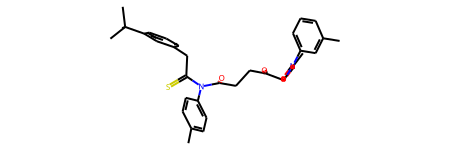

In [26]:
mol

In [27]:
get_bond_angle(mol, 'CCC')

[120.98540070985567,
 110.5184263859912,
 111.72513887324865,
 110.55725283913641,
 109.57012537551836,
 113.14328990853437,
 109.38317176053022,
 107.5405794161931,
 109.35669241430803,
 107.76930942463855]

In [28]:
get_dihedral_angle(mol, 'C12C-C12C-C12C')

[0.045132793993945625,
 0.31727147032581254,
 0.17285242518409213,
 -0.9927281223596802,
 1.3583139490243619,
 0.5494597503789072,
 -0.4217806618574352,
 0.3271925046830529,
 -0.37157612946052165,
 0.5110825390480466,
 -0.8870035185326582,
 0.5804163569490655,
 0.5822523917928671,
 -1.4202189137166252,
 1.1101170070611157,
 -0.9051568013128003,
 -0.594044431356375,
 0.03653065124493322]

In [29]:
get_dihedral_angle(mol, 'C1C-C1C-C1C')

[-104.17068974361275, -179.2089375789735]